# Analysis of facebook crawler

## 1. Needed libraries and functions, scroll down to section 2 for results

In [ ]:
#Some libraries we may need
!pip install nltk
!pip install labMTsimple
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install scipy
!pip install numpy

In [1]:
#Needed imports
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

from collections import Counter
import pandas as pd
import pylab as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram

#make nice plots
import seaborn as sns
sns.set(font_scale=1.2)
%matplotlib inline

#vocabulary from subtitles (take out all weird words)
with open("../data/es_full.txt") as f:
    set_words = set([_.split(" ")[0] for _ in f if int(_.split(" ")[1]) > 1])

In [14]:
def return_words(filename, stemming=True):
    """
    return list with all words from filename, and list of lists (one list per line in file)
    """
    with open(filename) as f:
        messages = f.readlines()
    
    
    messages = [[i for i in word_tokenize(text.lower()) if i in set_words] for text in messages]
    
    
    if stemming == True: 
        words = [stemmer.stem(w) for m in messages for w in m]
        
    else: 
        words = [w for m in messages for w in m]
    return words,messages


def merge_words(left_words,right_words):
    """
    create frequencies and merge two lists of words (left and right)
    """
    
    left_df = pd.DataFrame.from_dict(Counter(left_words),orient="index")
    right_df = pd.DataFrame.from_dict(Counter(right_words),orient="index")
    merged = pd.merge(left_df,right_df,left_index=True,right_index=True,how="outer")
    merged.columns = ["left","right"]
    return merged.fillna(0)

def plot(merged_df_limit):
    """
    bar plot summing to 100% according to the left prominence (perc_left)
    """
    left_df = merged_df_limit.loc[merged_df_limit["perc_left"]>50]
    right_df = merged_df_limit.loc[merged_df_limit["perc_left"]<50]
    for df in [left_df,right_df]:
        plt.figure(figsize=(15,1))
        i = 0
        for word,rest in df.iterrows():
            i += 1
            val = rest["perc_left"]
            if i == 1:
                label1 = 'PODEMOS'
                label2 = "PP"
            else:
                label1,label2 = "",""
            plt.bar(i,val,color="#4B0082",edgecolor="none",label=label1)
            plt.bar(i,100-val,bottom=val,color=(70/255,140/255,210/255),edgecolor="none",label=label2)
        plt.xticks(1.5+np.arange(df.shape[0]),df.index,rotation=90)
        plt.hlines(50,1,len(df)+1,color="white")
        plt.grid(False)
        plt.ylabel("Porcentaje de uso en grupos pro-Podemos")
        legend = plt.legend(frameon=True)
        #plt.savefig("./figures/representative_{}_words.pdf".format(len(merged_df_limit)))
        plt.show()

def get_prominence(merged_df):
    """
    get top 100 significant words
    """
    #normalize frequencies
    merged_df["right"] = merged_df["right"]/np.sum(merged_df["right"])
    merged_df["left"] = merged_df["left"]/np.sum(merged_df["left"])

    #calculate significance
    merged_df["expected"] = (merged_df["left"]+merged_df["right"])/2
    merged_df["chi2"] = (merged_df["left"]-merged_df["expected"])**2/merged_df["expected"]

    #calculate left prominence
    merged_df["perc_left"] = merged_df["left"]/(merged_df["left"]+merged_df["right"])*100

    #keep the 100 most prominent and significant
    #merged_df_limit = merged_df.loc[merged_df["chi2"]>2E-5]
    merged_df_limit = merged_df.loc[np.abs(50-merged_df["perc_left"])>20]
    merged_df_limit = merged_df_limit.loc[merged_df_limit["expected"] > 1E-5]
    merged_df_limit = merged_df_limit.sort_values(by="chi2",ascending=False)
    merged_df_limit = merged_df_limit.iloc[:100]

    #sort by left prominence
    return merged_df_limit.sort_values(by="perc_left",ascending=False)

def study_coocur(mess,vocab,threshold=0.4): 
    """
    plots the dendrogram with the similarity between woords based on co-ocurrences
    returns groups of similar words
    """
    coocu = np.zeros((len(vocab),len(vocab)))
    for i,mes in enumerate(mess):
        for i1,w1 in enumerate(vocab):
            if w1 in mes:
                for i2,w2 in enumerate(vocab[i1+1:]):
                    if w2 in mes:
                        coocu[i1,i2+i1+1] += 1

    vals = []
    for i in range(len(vocab)):
        for j in range(i+1,len(vocab)):
            vals.append(1./(1+coocu[i,j]))

    data_dist = vals

    #print(data_dist)
    fig = plt.figure(figsize=(4,18))

    # plot first dendrogram:
    ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
    Y = linkage(data_dist, method='weighted') # method?

    t = max(Y[:, 2]) * threshold
    Z1 = dendrogram(Y, orientation='right',
                leaf_font_size=18,color_threshold=t,labels=vocab) # adding/removing the axes
                #labels=["Profit","Decay","Profit \n(Ratio)","IMDB rating","Metascore","RottenT \nAudience","RottenT \nCritics","Profit \n(Deviation)"],
    ax1.set_xticks([]) # turn off xticks
    
    plt.grid(False)
    #plt.savefig("./figures/vocab_{}.pdf".format(which))
    plt.show()
    groups = []
    for i,g in pd.DataFrame.from_dict(dict(zip(Z1["ivl"],Z1["color_list"])),orient="index").groupby(0):
        if  i != "b":
            groups.append(list(g.index))
        else:
            for _ in g.index:
                groups.append(_)
    return groups

## 2. Extract messages and words

In [7]:
#All real words in the two groups
left_words,left_messages = return_words("../data/left_comments.txt",stemming=True)
right_words,right_messages = return_words("../data/right_comments.txt",stemming=True)

#All real words in each comment (one string per comment)
left_mess = [" ".join(lm) for lm in left_messages]
right_mess = [" ".join(rm) for rm in right_messages]

## 3. Look at individual words

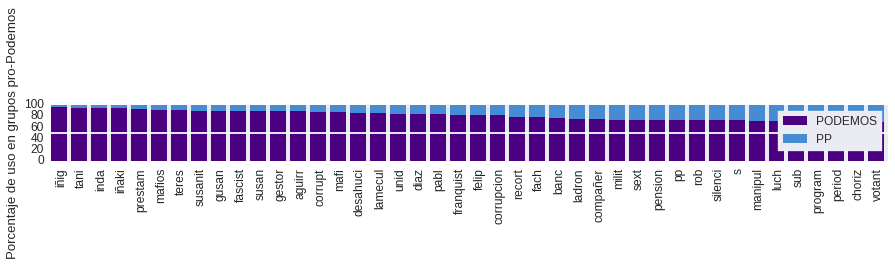

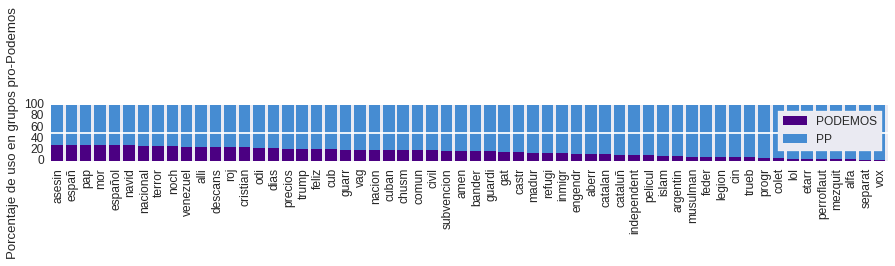

In [10]:
#merge by word
merged_df_iw = merge_words(left_words,right_words)
merged_df_limit_iw = get_prominence(merged_df_iw)
plot(merged_df_limit_iw)

In [11]:
left_vocab_iw = sorted(list(merged_df_limit_iw.loc[merged_df_limit_iw["perc_left"]>50].index))
right_vocab_iw = sorted(list(merged_df_limit_iw.loc[merged_df_limit_iw["perc_left"]<50].index))

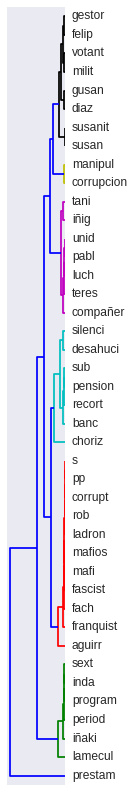

In [16]:
left_groups_iw = study_coocur(left_mess,left_vocab_iw,0.2)


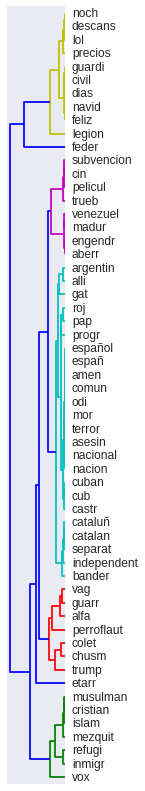

In [18]:
right_groups_iw = study_coocur(right_mess,right_vocab_iw,0.3)


## Look at groups of three words

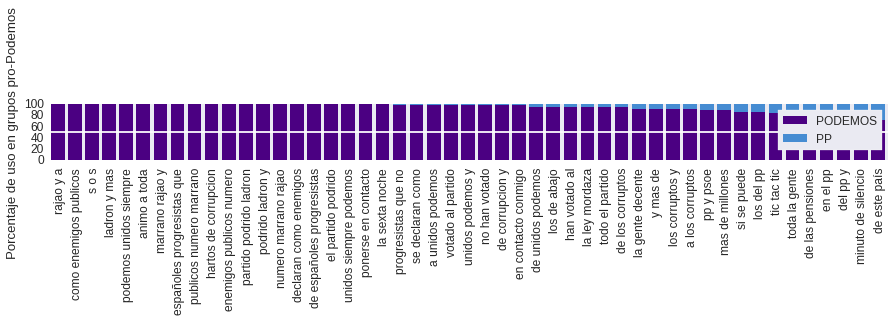

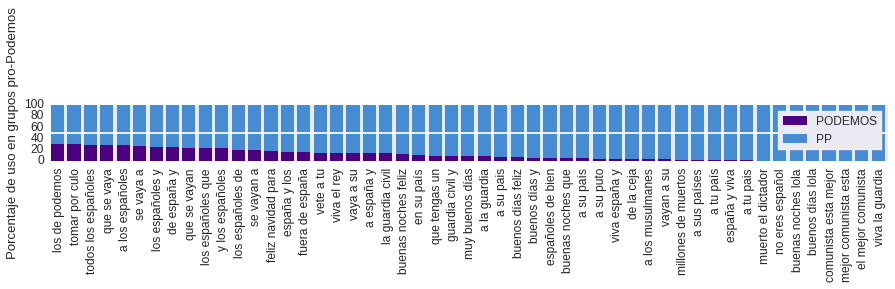

In [19]:
#trigrams
left_trigrams = [" ".join(lm[i:i+3]) for lm in left_messages for i in range(len(lm)-3)]
right_trigrams = [" ".join(lm[i:i+3]) for lm in right_messages for i in range(len(lm)-3)]
merged_df_tri = merge_words(left_trigrams,right_trigrams)
merged_df_limit_tri = get_prominence(merged_df_tri)
plot(merged_df_limit_tri)

In [20]:
left_vocab_tri = sorted(list(merged_df_limit_tri.loc[merged_df_limit_tri["perc_left"]>50].index))
right_vocab_tri = sorted(list(merged_df_limit_tri.loc[merged_df_limit_tri["perc_left"]<50].index))

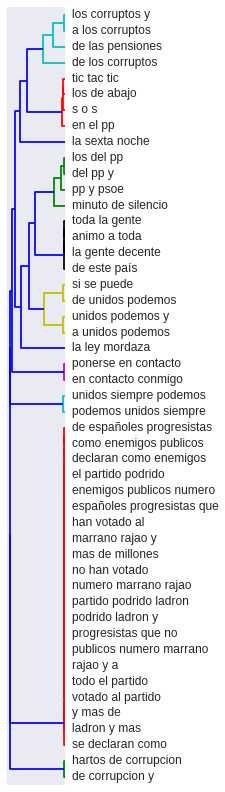

In [21]:
left_groups_tri = study_coocur(left_mess,left_vocab_tri)

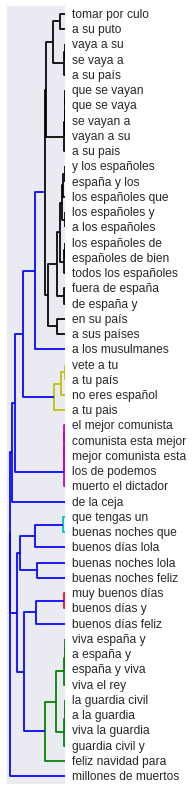

In [22]:
right_groups_tri = study_coocur(right_mess,right_vocab_tri)